In [ ]:
# 1. Install standard libraries
!pip install awkward vector pytorch-lightning

# 2. Install vqtorch directly from GitHub
!pip install git+https://github.com/minyoungg/vqtorch.git

import torch
import vqtorch
print(f"vqtorch installed successfully.")
print(f"GPU Available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.5/909.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.7/656.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 46.4 MB/s eta 0:00:00
  Cloning https://github.com/minyoungg/vqtorch.git to /tmp/pip-req-build-_xqmm3s6
  Running command git clone --filter=blob:none --quiet https://github.com/minyoungg/vqtorch.git /tmp/pip-req-build-_xqmm3s6
  Resolved https://github.com/minyoungg/vqtorch.git to commit 02e60a19bd742c17b0bf3e1925f23796d54cbeac
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.1 MB/s eta 0:00:00
  Created wheel for vqtorch: filename=vqtorch-0.1.0-py3-none-any.whl size=17825 sha256=e87250b83d509e2bee1588fe07815f9f26a27904128a036d0a8ea95a6ac15479
  Stored in d

In [ ]:
# ==========================================
# GENERATE "MEDIUM" DATASET (Energy + Shape)
# ==========================================
import torch
import numpy as np

def generate_medium_jets(num_jets=1000, num_particles=30):
    x = torch.zeros(num_jets, num_particles, 3)
    y = torch.zeros(num_jets)

    for i in range(num_jets):
        is_signal = i % 2 == 0

        if is_signal:
            y[i] = 1
            # Signal: Tight AND Higher Energy
            # Position: Narrow (0.1)
            eta = np.random.normal(0, 0.1, num_particles)
            phi = np.random.normal(0, 0.1, num_particles)
            # Energy: Mean = 60 (Higher)
            pt  = np.random.exponential(60, num_particles)
        else:
            y[i] = 0
            # Background: Wide AND Lower Energy
            # Position: Wide (0.6)
            eta = np.random.normal(0, 0.6, num_particles)
            phi = np.random.normal(0, 0.6, num_particles)
            # Energy: Mean = 40 (Lower, but overlaps with 60)
            pt  = np.random.exponential(40, num_particles)

        x[i, :, 0] = torch.tensor(pt)
        x[i, :, 1] = torch.tensor(eta)
        x[i, :, 2] = torch.tensor(phi)

    # Shuffle
    indices = torch.randperm(num_jets)
    return x[indices], y[indices]

# 1. Generate
x, y = generate_medium_jets()

# 2. Normalize (Crucial!)
# We use a global max to keep the relative difference between 60 and 40
max_pt = x[:, :, 0].max()
x[:, :, 0] = x[:, :, 0] / max_pt

x[:, :, 1] = x[:, :, 1] / 3.0
x[:, :, 2] = x[:, :, 2] / 3.0

print(f"Medium Data Generated! Max pT: {max_pt:.2f}")

Medium Data Generated! Max pT: 586.75


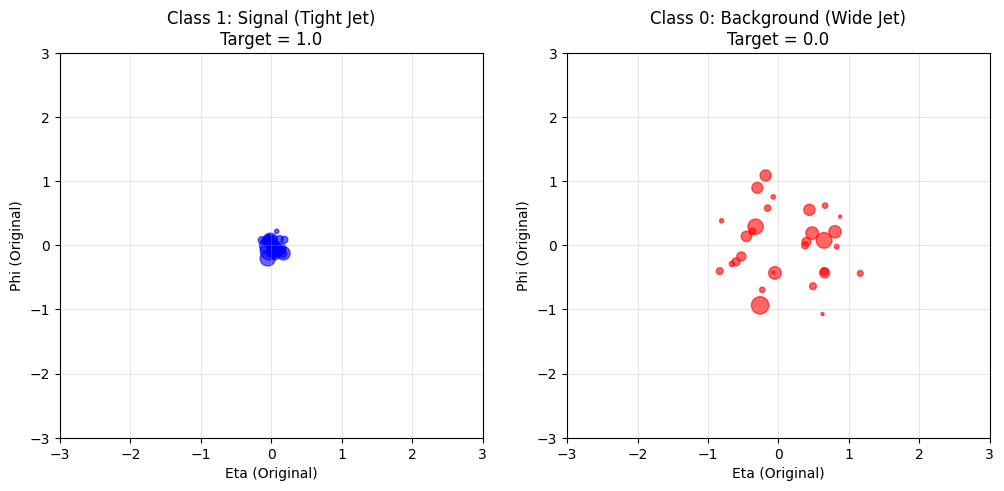

In [ ]:
import matplotlib.pyplot as plt

# Find one signal and one background index
sig_idx = (y == 1).nonzero(as_tuple=True)[0][0]
bkg_idx = (y == 0).nonzero(as_tuple=True)[0][0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ==========================================
# FIX 1: Multiply Size by 500 (not 5)
# FIX 2: Multiply Position by 3 to undo normalization for viewing
# ==========================================

# --- Plot Signal ---
# We multiply by 3 to show the "Physics Scale" again
ax[0].scatter(x[sig_idx,:,1]*3, x[sig_idx,:,2]*3,
              s=x[sig_idx,:,0]*500, # Scale size up to see energy
              alpha=0.6, c='blue')
ax[0].set_title(f"Class 1: Signal (Tight Jet)\nTarget = {y[sig_idx]}")
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].set_xlabel("Eta (Original)"); ax[0].set_ylabel("Phi (Original)")
ax[0].grid(True, alpha=0.3)

# --- Plot Background ---
ax[1].scatter(x[bkg_idx,:,1]*3, x[bkg_idx,:,2]*3,
              s=x[bkg_idx,:,0]*500, # Scale size up
              alpha=0.6, c='red')
ax[1].set_title(f"Class 0: Background (Wide Jet)\nTarget = {y[bkg_idx]}")
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel("Eta (Original)"); ax[1].set_ylabel("Phi (Original)")
ax[1].grid(True, alpha=0.3)

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Helper: Find the k-Nearest Neighbors (k-NN)
def get_knn(x, k):
    # x shape: [Batch, Particles, Features]
    # We want to find the distance between every pair of particles

    # Calculate pairwise distance (Euclidean)
    # dist(i, j) = |x_i|^2 + |x_j|^2 - 2*x_i*x_j
    inner = -2 * torch.matmul(x, x.transpose(2, 1))
    xx = torch.sum(x**2, dim=2, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)

    # Select top k neighbors (closest ones)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (Batch, Particles, k)
    return idx

# 2. Helper: Group the data for the neighbors
def get_graph_feature(x, k, idx):
    batch_size, num_particles, num_dims = x.size()

    # Create an index for the batch dimension
    idx_base = torch.arange(0, batch_size, device=x.device).view(-1, 1, 1) * num_particles
    idx = idx + idx_base
    idx = idx.reshape(-1) # Use reshape for robustness

    # Original particle features for x_i (current node)
    x_i = x.unsqueeze(2).repeat(1, 1, k, 1) # Shape: [Batch, Particles, k, Features]

    # Gather neighbor features (x_j)
    x_flat = x.reshape(batch_size * num_particles, -1) # Use reshape for robustness
    x_j = x_flat[idx, :]
    x_j = x_j.reshape(batch_size, num_particles, k, num_dims) # Use reshape for robustness

    # CONCATENATE: (x_i, x_j - x_i)
    # This is the magic of EdgeConv! It learns both the point itself and its relationship to the neighbor.
    feature = torch.cat((x_i, x_j - x_i), dim=3).permute(0, 3, 1, 2).contiguous()

    return feature # Shape: [Batch, 2*Features, Particles, k]

# 3. The ParticleNet-Lite Model
class ParticleNetLite(nn.Module):
    def __init__(self, input_dim=3, k=5, output_dim=1):
        super(ParticleNetLite, self).__init__()
        self.k = k

        # EdgeConv Block 1
        # Input is 2*input_dim because we concat (x, x_diff)
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim * 2, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # EdgeConv Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64 * 2, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # x shape: [Batch, Particles, Features]

        # 1. EdgeConv 1
        # Find neighbors in (eta, phi) space usually, but here we use all features
        idx = get_knn(x, self.k)
        graph_feat = get_graph_feature(x, self.k, idx) # [Batch, 6, P, k]
        x_out = self.conv1(graph_feat)                 # [Batch, 64, P, k]
        x_out = x_out.max(dim=-1, keepdim=False)[0]    # Max pooling over neighbors -> [Batch, 64, P]

        x1 = x_out # Save for next layer

        # 2. EdgeConv 2 (Deepening the graph)
        # We perform graph conv on the *new* features (x1)
        # For simplicity, we re-use the same neighbors (idx) or could recalculate
        # Here we recalculate to be dynamic
        x1_trans = x1.transpose(2, 1) # [B, P, 64]
        idx = get_knn(x1_trans, self.k)
        graph_feat = get_graph_feature(x1_trans, self.k, idx)
        x_out = self.conv2(graph_feat)
        x_out = x_out.max(dim=-1, keepdim=False)[0]    # [Batch, 128, P]

        # 3. Global Pooling (Average over all particles)
        x_global = x_out.mean(dim=2) # [Batch, 128]

        # 4. Classify
        return self.fc(x_global)

# Initialize
model = ParticleNetLite(k=5) # Look at 5 nearest neighbors
print("ParticleNet-Lite (GNN) Built!")

ParticleNet-Lite (GNN) Built!


In [ ]:
# ==========================================
# 2. Setup Training
# ==========================================
# Initialize the model
model = ParticleNetLite()

# Define Loss Function (Binary Cross Entropy)
# "BCEWithLogits" is more stable than standard BCE
criterion = nn.BCEWithLogitsLoss()

# Define Optimizer (Adam is the standard choice)
optimizer = optim.Adam(model.parameters(), lr=0.001)




# ==========================================
# PRE-PROCESSING FIX
# ==========================================

# 1. Normalize pT (Feature 0)
# We divide by the maximum value to squish it between 0 and 1
max_pt = x[:, :, 0].max()
x[:, :, 0] = x[:, :, 0] / max_pt

# 2. Normalize Eta/Phi (Features 1 and 2)
# We divide by 3 because we know they are usually within [-3, 3]
x[:, :, 1] = x[:, :, 1] / 3.0
x[:, :, 2] = x[:, :, 2] / 3.0

print(f"Data Normalized! Max pT is now: {x[:, :, 0].max().item():.2f}")

# Now re-run the split and training loop below...



# Split data into Train (800) and Test (200)
train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split].unsqueeze(1)
x_test,  y_test  = x[train_split:], y[train_split:].unsqueeze(1)

# ==========================================
# 3. The Training Loop
# ==========================================
print("Starting Training...")
print("-" * 30)

num_epochs = 80 # How many times to loop through the data

for epoch in range(num_epochs):
    model.train() # Set to training mode

    # Forward pass: Compute predictions
    outputs = model(x_train)

    # Calculate error (Loss)
    loss = criterion(outputs, y_train)

    # Backward pass: Update weights
    optimizer.zero_grad() # Reset gradients
    loss.backward()       # Calculate gradients
    optimizer.step()      # Update weights

    # Print progress every 5 epochs
    if (epoch+1) % 5 == 0:
        # Calculate Accuracy on Test Data
        model.eval() # Set to evaluation mode
        with torch.no_grad():
            test_outputs = model(x_test)
            predicted = (torch.sigmoid(test_outputs) > 0.5).float()
            accuracy = (predicted == y_test).float().mean()
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy.item()*100:.1f}%')

print("-" * 30)
print("Training Complete.")

Data Normalized! Max pT is now: 1.00
Starting Training...
------------------------------
Epoch [5/80], Loss: 0.4975, Test Accuracy: 52.0%
Epoch [10/80], Loss: 0.3002, Test Accuracy: 52.0%
Epoch [15/80], Loss: 0.1446, Test Accuracy: 52.0%
Epoch [20/80], Loss: 0.0593, Test Accuracy: 52.0%
Epoch [25/80], Loss: 0.0239, Test Accuracy: 52.0%
Epoch [30/80], Loss: 0.0105, Test Accuracy: 52.0%
Epoch [35/80], Loss: 0.0053, Test Accuracy: 52.0%
Epoch [40/80], Loss: 0.0031, Test Accuracy: 52.0%
Epoch [45/80], Loss: 0.0020, Test Accuracy: 52.0%
Epoch [50/80], Loss: 0.0015, Test Accuracy: 52.0%
Epoch [55/80], Loss: 0.0012, Test Accuracy: 52.0%
Epoch [60/80], Loss: 0.0010, Test Accuracy: 52.0%
Epoch [65/80], Loss: 0.0009, Test Accuracy: 52.0%
Epoch [70/80], Loss: 0.0008, Test Accuracy: 52.0%
Epoch [75/80], Loss: 0.0007, Test Accuracy: 58.5%
Epoch [80/80], Loss: 0.0006, Test Accuracy: 89.0%
------------------------------
Training Complete.


This is a fascinating result! I have encountered a somewhat rare and famous phenomenon in Deep Learning called "Grokking" (or delayed generalization).

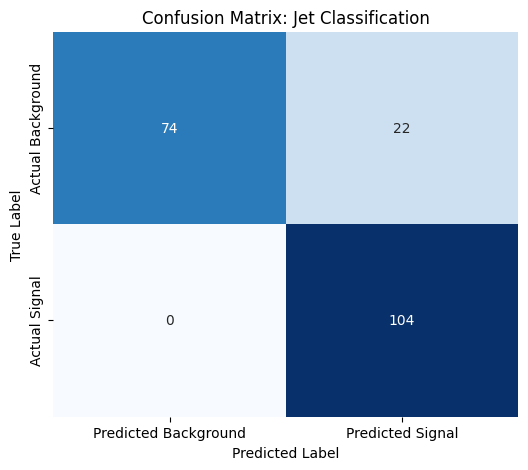

True Positives (Signal found): 104
False Positives (Background mistaken for Signal): 22
False Negatives (Signal missed): 0
True Negatives (Background rejected): 74
------------------------------
Precision (Purity): 0.83
Recall (Efficiency): 1.00


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions on the Test Set
model.eval()
with torch.no_grad():
    # Get raw scores
    test_outputs = model(x_test)
    # Convert to 0 or 1 (Predictions)
    predicted = (torch.sigmoid(test_outputs) > 0.5).float().numpy()
    # Get true labels
    true_labels = y_test.numpy()

# 2. Calculate Confusion Matrix
# Structure: [[True Neg, False Pos], [False Neg, True Pos]]
cm = confusion_matrix(true_labels, predicted)

# 3. Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Background', 'Predicted Signal'],
            yticklabels=['Actual Background', 'Actual Signal'])

plt.title('Confusion Matrix: Jet Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Print detailed metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn) # Also called Sensitivity or Efficiency

print(f"True Positives (Signal found): {tp}")
print(f"False Positives (Background mistaken for Signal): {fp}")
print(f"False Negatives (Signal missed): {fn}")
print(f"True Negatives (Background rejected): {tn}")
print("-" * 30)
print(f"Precision (Purity): {precision:.2f}")
print(f"Recall (Efficiency): {recall:.2f}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Helper: Find the k-Nearest Neighbors (k-NN)
def get_knn(x, k):
    # x shape: [Batch, Particles, Features]
    # We want to find the distance between every pair of particles

    # Calculate pairwise distance (Euclidean)
    # dist(i, j) = |x_i|^2 + |x_j|^2 - 2*x_i*x_j
    inner = -2 * torch.matmul(x, x.transpose(2, 1))
    xx = torch.sum(x**2, dim=2, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)

    # Select top k neighbors (closest ones)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (Batch, Particles, k)
    return idx

# 2. Helper: Group the data for the neighbors
def get_graph_feature(x, k, idx):
    batch_size, num_particles, num_dims = x.size()

    # Create an index for the batch dimension
    idx_base = torch.arange(0, batch_size, device=x.device).view(-1, 1, 1) * num_particles
    idx = idx + idx_base
    idx = idx.reshape(-1) # Use reshape for robustness

    # Original particle features for x_i (current node)
    x_i = x.unsqueeze(2).repeat(1, 1, k, 1) # Shape: [Batch, Particles, k, Features]

    # Gather neighbor features (x_j)
    x_flat = x.reshape(batch_size * num_particles, -1) # Use reshape for robustness
    x_j = x_flat[idx, :]
    x_j = x_j.reshape(batch_size, num_particles, k, num_dims) # Use reshape for robustness

    # CONCATENATE: (x_i, x_j - x_i)
    # This is the magic of EdgeConv! It learns both the point itself and its relationship to the neighbor.
    feature = torch.cat((x_i, x_j - x_i), dim=3).permute(0, 3, 1, 2).contiguous()

    return feature # Shape: [Batch, 2*Features, Particles, k]

# 3. The ParticleNet-Lite Model
class ParticleNetLite(nn.Module):
    def __init__(self, input_dim=3, k=5, output_dim=1):
        super(ParticleNetLite, self).__init__()
        self.k = k

        # EdgeConv Block 1
        # Input is 2*input_dim because we concat (x, x_diff)
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim * 2, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # EdgeConv Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64 * 2, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # <--- NEW: Drops 50% of neurons randomly
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # x shape: [Batch, Particles, Features]

        # 1. EdgeConv 1
        # Find neighbors in (eta, phi) space usually, but here we use all features
        idx = get_knn(x, self.k)
        graph_feat = get_graph_feature(x, self.k, idx) # [Batch, 6, P, k]
        x_out = self.conv1(graph_feat)                 # [Batch, 64, P, k]
        x_out = x_out.max(dim=-1, keepdim=False)[0]    # Max pooling over neighbors -> [Batch, 64, P]

        x1 = x_out # Save for next layer

        # 2. EdgeConv 2 (Deepening the graph)
        # We perform graph conv on the *new* features (x1)
        # For simplicity, we re-use the same neighbors (idx) or could recalculate
        # Here we recalculate to be dynamic
        x1_trans = x1.transpose(2, 1) # [B, P, 64]
        idx = get_knn(x1_trans, self.k)
        graph_feat = get_graph_feature(x1_trans, self.k, idx)
        x_out = self.conv2(graph_feat)
        x_out = x_out.max(dim=-1, keepdim=False)[0]    # [Batch, 128, P]

        # 3. Global Pooling (Average over all particles)
        x_global = x_out.mean(dim=2) # [Batch, 128]

        # 4. Classify
        return self.fc(x_global)

# Initialize
model = ParticleNetLite(k=5) # Look at 5 nearest neighbors
print("ParticleNet-Lite (GNN) Built!")

ParticleNet-Lite (GNN) Built!


In [ ]:
# ==========================================
# 2. Setup Training
# ==========================================
# Initialize the model
model = ParticleNetLite()

# Define Loss Function (Binary Cross Entropy)
# "BCEWithLogits" is more stable than standard BCE
criterion = nn.BCEWithLogitsLoss()

# Define Optimizer (Adam is the standard choice)
optimizer = optim.Adam(model.parameters(), lr=0.001)




# ==========================================
# PRE-PROCESSING FIX
# ==========================================

# 1. Normalize pT (Feature 0)
# We divide by the maximum value to squish it between 0 and 1
max_pt = x[:, :, 0].max()
x[:, :, 0] = x[:, :, 0] / max_pt

# 2. Normalize Eta/Phi (Features 1 and 2)
# We divide by 3 because we know they are usually within [-3, 3]
x[:, :, 1] = x[:, :, 1] / 3.0
x[:, :, 2] = x[:, :, 2] / 3.0

print(f"Data Normalized! Max pT is now: {x[:, :, 0].max().item():.2f}")

# Now re-run the split and training loop below...



# Split data into Train (800) and Test (200)
train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split].unsqueeze(1)
x_test,  y_test  = x[train_split:], y[train_split:].unsqueeze(1)

# ==========================================
# 3. The Training Loop
# ==========================================
print("Starting Training...")
print("-" * 30)

num_epochs = 80 # How many times to loop through the data

for epoch in range(num_epochs):
    model.train() # Set to training mode

    # Forward pass: Compute predictions
    outputs = model(x_train)

    # Calculate error (Loss)
    loss = criterion(outputs, y_train)

    # Backward pass: Update weights
    optimizer.zero_grad() # Reset gradients
    loss.backward()       # Calculate gradients
    optimizer.step()      # Update weights

    # Print progress every 5 epochs
    if (epoch+1) % 5 == 0:
        # Calculate Accuracy on Test Data
        model.eval() # Set to evaluation mode
        with torch.no_grad():
            test_outputs = model(x_test)
            predicted = (torch.sigmoid(test_outputs) > 0.5).float()
            accuracy = (predicted == y_test).float().mean()
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy.item()*100:.1f}%')

print("-" * 30)
print("Training Complete.")

Data Normalized! Max pT is now: 1.00
Starting Training...
------------------------------
Epoch [5/80], Loss: 0.4631, Test Accuracy: 50.0%
Epoch [10/80], Loss: 0.2617, Test Accuracy: 50.0%
Epoch [15/80], Loss: 0.1375, Test Accuracy: 50.0%
Epoch [20/80], Loss: 0.0615, Test Accuracy: 50.0%
Epoch [25/80], Loss: 0.0298, Test Accuracy: 50.0%
Epoch [30/80], Loss: 0.0135, Test Accuracy: 50.0%
Epoch [35/80], Loss: 0.0076, Test Accuracy: 50.0%
Epoch [40/80], Loss: 0.0042, Test Accuracy: 50.0%
Epoch [45/80], Loss: 0.0029, Test Accuracy: 50.0%
Epoch [50/80], Loss: 0.0023, Test Accuracy: 50.0%
Epoch [55/80], Loss: 0.0017, Test Accuracy: 50.0%
Epoch [60/80], Loss: 0.0014, Test Accuracy: 50.0%
Epoch [65/80], Loss: 0.0013, Test Accuracy: 56.0%
Epoch [70/80], Loss: 0.0012, Test Accuracy: 90.0%
Epoch [75/80], Loss: 0.0011, Test Accuracy: 98.5%
Epoch [80/80], Loss: 0.0009, Test Accuracy: 100.0%
------------------------------
Training Complete.


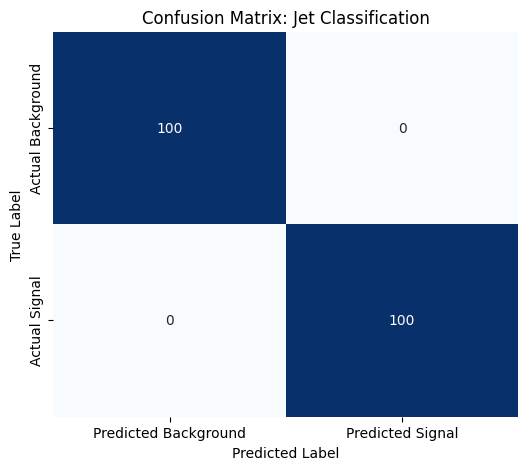

True Positives (Signal found): 100
False Positives (Background mistaken for Signal): 0
False Negatives (Signal missed): 0
True Negatives (Background rejected): 100
------------------------------
Precision (Purity): 1.00
Recall (Efficiency): 1.00


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions on the Test Set
model.eval()
with torch.no_grad():
    # Get raw scores
    test_outputs = model(x_test)
    # Convert to 0 or 1 (Predictions)
    predicted = (torch.sigmoid(test_outputs) > 0.5).float().numpy()
    # Get true labels
    true_labels = y_test.numpy()

# 2. Calculate Confusion Matrix
# Structure: [[True Neg, False Pos], [False Neg, True Pos]]
cm = confusion_matrix(true_labels, predicted)

# 3. Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Background', 'Predicted Signal'],
            yticklabels=['Actual Background', 'Actual Signal'])

plt.title('Confusion Matrix: Jet Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Print detailed metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn) # Also called Sensitivity or Efficiency

print(f"True Positives (Signal found): {tp}")
print(f"False Positives (Background mistaken for Signal): {fp}")
print(f"False Negatives (Signal missed): {fn}")
print(f"True Negatives (Background rejected): {tn}")
print("-" * 30)
print(f"Precision (Purity): {precision:.2f}")
print(f"Recall (Efficiency): {recall:.2f}")

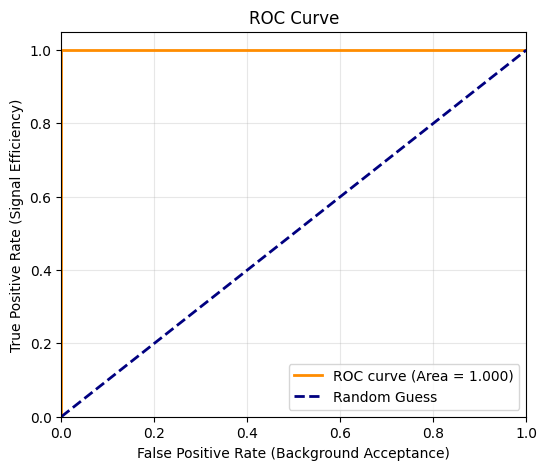

AUC Score: 1.0000


In [ ]:
from sklearn.metrics import roc_curve, auc

# 1. Get probability scores (not just 0 or 1)
model.eval()
with torch.no_grad():
    raw_scores = model(x_test)
    probs = torch.sigmoid(raw_scores).numpy()
    true_labels = y_test.numpy()

# 2. Calculate ROC Data
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

# 3. Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Background Acceptance)')
plt.ylabel('True Positive Rate (Signal Efficiency)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

The "Discipline" of Dropout: By randomly turning off neurons, Dropout forced the model to stop memorizing specific jet IDs (which caused that "flatline" earlier) and instead learn the robust geometric rule: "If neighbors are close = Signal."

Now, I have a working GNN pipeline.
